In [241]:
import os, math
from datetime import datetime
from datetime import timedelta

import pandas as pd
from pandas import DataFrame, Series
import numpy as np

from scipy.sparse import lil_matrix

import pysal
import pysal.esda as esda
import pysal.esda.mapclassify as mc

import geopandas as gpd
from geopandas.tools import sjoin
import geoplot as gplt
from shapely.geometry import Point, Polygon

import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

from util import *

# Data Loading

In [379]:
%%time
detail_data=DataFrame()
loaded_files = []
for filename in os.listdir("data/details"):
    if filename.endswith(".csv"):
        loaded_files.append(pd.read_csv("data/details/"+filename))
detail_data = pd.concat(loaded_files)
detail_data.reset_index(drop=True,inplace=True)

<string>:2: DtypeWarning: Columns (26,28) have mixed types. Specify dtype option on import or set low_memory=False.
<string>:2: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
<string>:2: DtypeWarning: Columns (29,34,35,37) have mixed types. Specify dtype option on import or set low_memory=False.


Wall time: 24.1 s


In [380]:
detail_data.head()

,BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME,END_YEARMONTH,END_DAY,END_TIME,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,...,END_RANGE,END_AZIMUTH,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE,DATA_SOURCE
0,195004,28,1445,195004,28,1445,NaN,10096222,OKLAHOMA,40.0,...,0.0,NaN,NaN,35.12,-99.20,35.17,-99.20,NaN,NaN,PUB
1,195004,29,1530,195004,29,1530,NaN,10120412,TEXAS,48.0,...,0.0,NaN,NaN,31.90,-98.60,31.73,-98.60,NaN,NaN,PUB
2,195007,5,1800,195007,5,1800,NaN,10104927,PENNSYLVANIA,42.0,...,0.0,NaN,NaN,40.58,-75.70,40.65,-75.47,NaN,NaN,PUB
3,195007,5,1830,195007,5,1830,NaN,10104928,PENNSYLVANIA,42.0,...,0.0,NaN,NaN,40.60,-76.75,NaN,NaN,NaN,NaN,PUB
4,195007,24,1440,195007,24,1440,NaN,10104929,PENNSYLVANIA,42.0,...,0.0,NaN,NaN,41.63,-79.68,NaN,NaN,NaN,NaN,PUB


# Convert the Time related strings to a DateTime column

In [381]:
%%time
# Pad the "DAY" columns to length 2 so the date parser can do it's thing
detail_data.BEGIN_DAY = detail_data.BEGIN_DAY.map(str).str.pad(2,fillchar='0')
detail_data.END_DAY = detail_data.END_DAY.map(str).str.pad(2,fillchar='0')
# ditto with the Time
detail_data.BEGIN_TIME = detail_data.BEGIN_TIME.map(str).str.pad(4,fillchar='0')
detail_data.END_TIME = detail_data.END_TIME.map(str).str.pad(4,fillchar='0')
# create a new column by concating the three date/time related columns and convert the result to a datetime
detail_data['BEGIN_DATE']=detail_data.BEGIN_YEARMONTH.map(str)+" "+detail_data.BEGIN_DAY.map(str)+" "+detail_data.BEGIN_TIME.map(str)
detail_data.BEGIN_DATE=pd.to_datetime(detail_data.BEGIN_DATE, format='%Y%m %d %H%M', errors='coerce')

detail_data['END_DATE']=detail_data.END_YEARMONTH.map(str)+" "+detail_data.END_DAY.map(str)+" "+detail_data.END_TIME.map(str)
detail_data.END_DATE=pd.to_datetime(detail_data.END_DATE, format='%Y%m %d %H%M', errors='coerce')

# drop the old columns
detail_data = detail_data.drop(['BEGIN_YEARMONTH', "END_YEARMONTH",'BEGIN_DAY', "END_DAY", "BEGIN_TIME", "END_TIME"], axis=1)
detail_data = detail_data.drop(['YEAR', "MONTH_NAME",'END_DATE_TIME', "BEGIN_DATE_TIME"], axis=1)

# Columns I don't think I need at the momment
detail_data = detail_data.drop(['WFO', 'SOURCE',
       'MAGNITUDE', 'MAGNITUDE_TYPE', 'FLOOD_CAUSE', 'CATEGORY', 'TOR_F_SCALE',
       'TOR_LENGTH', 'TOR_WIDTH', 'TOR_OTHER_WFO', 'TOR_OTHER_CZ_STATE',
       'TOR_OTHER_CZ_FIPS', 'TOR_OTHER_CZ_NAME', 'BEGIN_RANGE',
       'BEGIN_AZIMUTH', 'BEGIN_LOCATION', 'END_RANGE', 'END_AZIMUTH',
       'END_LOCATION','EPISODE_NARRATIVE', 'EVENT_NARRATIVE', 'DATA_SOURCE'], axis=1)

# columns I'm less sure I don't need, but it'll make things easier for the time being
detail_data = detail_data.drop(['INJURIES_DIRECT',
       'INJURIES_INDIRECT', 'DEATHS_DIRECT', 'DEATHS_INDIRECT',
       'DAMAGE_PROPERTY', 'DAMAGE_CROPS'], axis=1)

Wall time: 32.4 s


# Correcting input errors
There's some input errors with the Lat/Long coordinates - decimal place is just shifted, so dividing those by ten gives us the correct value (Affects 2080 rows)

In [382]:
detail_data.columns

Index(['EPISODE_ID', 'EVENT_ID', 'STATE', 'STATE_FIPS', 'EVENT_TYPE',
       'CZ_TYPE', 'CZ_FIPS', 'CZ_NAME', 'CZ_TIMEZONE', 'BEGIN_LAT',
       'BEGIN_LON', 'END_LAT', 'END_LON', 'BEGIN_DATE', 'END_DATE'],
      dtype='object')

In [383]:
detail_data.loc[detail_data.BEGIN_LON < -180, 'BEGIN_LON']=detail_data.loc[detail_data.BEGIN_LON < -180, 'BEGIN_LON']/10
detail_data.loc[detail_data.END_LON < -180, 'END_LON']=detail_data.loc[detail_data.END_LON < -180, 'END_LON']/10

Fix inconsistencies in event type tagging

In [384]:
detail_data.loc[detail_data.EVENT_TYPE.isin(['HAIL FLOODING', 'HAIL/ICY ROADS']), 'EVENT_TYPE'] = 'Hail'
detail_data.loc[detail_data.EVENT_TYPE.isin(['Heavy Wind']), 'EVENT_TYPE'] = 'High Wind'
detail_data.loc[detail_data.EVENT_TYPE.isin(['High Snow']), 'EVENT_TYPE'] = 'Heavy Snow'
detail_data.loc[detail_data.EVENT_TYPE.isin(['High Snow']), 'EVENT_TYPE'] = 'Heavy Snow'
detail_data.loc[detail_data.EVENT_TYPE.isin(
    [
        'TORNADOES, TSTM WIND, HAIL',
        'THUNDERSTORM WINDS/FLOODING',
        'THUNDERSTORM WINDS/FLASH FLOOD',
        'THUNDERSTORM WINDS LIGHTNING',
        'THUNDERSTORM WIND/ TREES',
        'THUNDERSTORM WIND/ TREE',
        'THUNDERSTORM WINDS FUNNEL CLOU',
        'THUNDERSTORM WINDS/HEAVY RAIN',
        'THUNDERSTORM WINDS HEAVY RAIN',
        'THUNDERSTORM WINDS/ FLOOD'
    ]
), 'EVENT_TYPE'] = 'Thunderstorm Wind'
detail_data.loc[detail_data.EVENT_TYPE.isin(['TORNADO/WATERSPOUT']), 'EVENT_TYPE'] = 'Tornado'
detail_data.loc[detail_data.EVENT_TYPE.isin(['Landslide']), 'EVENT_TYPE'] = 'Debris Flow'
detail_data.loc[detail_data.EVENT_TYPE.isin(['Volcanic Ashfall']), 'EVENT_TYPE'] = 'Volcanic Ash'

Drop 14 rows tagged "Northern Lights" and a single row tagged 'OTHER'.

In [385]:
detail_data.drop(detail_data[detail_data.EVENT_TYPE.isin(['Northern Lights', 'OTHER'])].index, inplace=True)

# Trim the data to just the Continental US

In [447]:
detail_data = detail_data[
        ((detail_data.BEGIN_LON > -124.7844079) &
        (detail_data.BEGIN_LON < -66.9513812) &
        (detail_data.BEGIN_LAT > 24.7433195) &
        (detail_data.BEGIN_LAT < 49.3457868)) |
        (detail_data.BEGIN_LAT.isnull())
    ].copy()

# Create Categorical Index

Create two categories - one based off of the event type and another based on my not very scientific classification

In [387]:
detail_data.EVENT_TYPE = detail_data.EVENT_TYPE.astype("category")
detail_data['EVENT_CODE'] = detail_data.EVENT_TYPE.cat.codes

In [388]:
detail_data['META_TYPE'] = None
detail_data.loc[detail_data.EVENT_TYPE.isin(
    [
        'Avalanche',
        'Blizzard',
        'Cold/Wind Chill',
        'Extreme Cold/Wind Chill',
        'Freezing Fog',
        'Frost/Freeze',
        'Hail',
        'Heavy Snow',
        'Ice Storm',
        'Lake-Effect Snow',
        'Marine Hail',
        'Sleet',
        'Winter Storm',
        'Winter Weather'
    ]
), 'META_TYPE'] = 'Cold'

detail_data.loc[detail_data.EVENT_TYPE.isin(
    [
        'Dense Smoke',
        'Drought',
        'Excessive Heat',
        'Heat',
        'Volcanic Ash',
        'Wildfire'
    ]
), 'META_TYPE'] = 'Heat'

detail_data.loc[detail_data.EVENT_TYPE.isin(
    [
        'Debris Flow',
        'Dense Fog',
        'Lightning',
        'Marine Dense Fog',
        'Marine Lightning'
    ]
), 'META_TYPE'] = 'Other'

detail_data.loc[detail_data.EVENT_TYPE.isin(
    [
        'Astronomical Low Tide',
        'Coastal Flood',
        'Flash Flood',
        'Flood',
        'Heavy Rain',
        'High Surf',
        'Lakeshore Flood',
        'Rip Current',
        'Seiche',
        'Sneakerwave',
        'Storm Surge/Tide',
        'Tsunami',
        'Waterspout'
    ]
), 'META_TYPE'] = 'Water'

detail_data.loc[detail_data.EVENT_TYPE.isin(
    [
        'Dust Devil',
        'Dust Storm',
        'Funnel Cloud',
        'High Wind',
        'Hurricane',
        'Hurricane (Typhoon)',
        'Marine High Wind',
        'Marine Hurricane/Typhoon',
        'Marine Strong Wind',
        'Marine Thunderstorm Wind',
        'Marine Tropical Depression',
        'Marine Tropical Storm',
        'Strong Wind',
        'Thunderstorm Wind',
        'Tornado',
        'Tropical Depression',
        'Tropical Storm'
    ]
), 'META_TYPE'] = 'Wind'
detail_data.META_TYPE = detail_data.META_TYPE.astype("category")
detail_data['META_CODE'] = detail_data.META_TYPE.cat.codes

# Fill in missing data
The US Census Gazetteer contains a file which provides Lat/Long for every county in the US. Combined with the FIPs codes, we can give estimated locations for events with no clear starting point (about 1/3 of the dataset - things like "drought" or "Strong Wind" that don't have a clearly defined geographic location).
Dataset from https://www.census.gov/geo/maps-data/data/gazetteer2017.html

In [389]:
county_df = pd.read_csv('data/2017_Gaz_counties_national.txt', sep='\t', engine='python')
county_df['FIPS'] = county_df['GEOID'].apply(lambda x: '{0:0>5}'.format(x))
county_df.set_index("FIPS", inplace=True)
county_df.head(3)

,USPS,GEOID,ANSICODE,NAME,ALAND,AWATER,ALAND_SQMI,AWATER_SQMI,INTPTLAT,INTPTLONG
FIPS,,,,,,,,,,
01001,AL,1001,161526,Autauga County,1539614693,25744269,594.449,9.940,32.532237,-86.646440
01003,AL,1003,161527,Baldwin County,4117605847,1133109409,1589.817,437.496,30.659218,-87.746067
01005,AL,1005,161528,Barbour County,2292144656,50538698,885.002,19.513,31.870253,-85.405104


### Fill in Lat/Lon for events based on county centroid
Create a new column that combines the State and County FIPS so we can look them up (gets coordinates for ~250k entries)

In [390]:
detail_data['FIPS'] = detail_data['STATE_FIPS']*1000+detail_data['CZ_FIPS']
detail_data['FIPS'].fillna(0, inplace=True)
detail_data['FIPS'] = detail_data['FIPS'].apply(lambda x: '{0:0>5}'.format(int(x)))

# drop the old columns, since we've condensed that data into one column
detail_data = detail_data.drop(['EPISODE_ID', 'EVENT_ID', 'STATE_FIPS', 'CZ_TYPE', 'CZ_FIPS', 'CZ_TIMEZONE'], axis=1)

Try to match up FIPS ids for events with no location info, and fill in the begin lat/lon with that counties centroid

In [392]:
# temporaily assing FIPS as the index
detail_data.set_index("FIPS", inplace=True)

# left join on the county dataframe to get a column of county centroids
detail_data = detail_data.join(county_df[['INTPTLAT', 'INTPTLONG']], on="FIPS")

# reset the index to avoid duplicate issues in a sec 
detail_data.reset_index(inplace=True)

# if the lat/lon are blank, and we were able to match it to a FIPS code, add the country centroid as the event lat/lon
detail_data.loc[detail_data.BEGIN_LAT.isnull(), 'BEGIN_LAT'] = detail_data.INTPTLAT
detail_data.loc[detail_data.BEGIN_LON.isnull(), 'BEGIN_LON'] = detail_data.INTPTLONG

#drop the extra columns now that we don't need them
detail_data.drop(['INTPTLAT', 'INTPTLONG'], axis=1, inplace=True)

### Fill in missing Date Entries
Some entries have an end date but no starting date. We're just going to fill in the latter with the former (~110k entries)

In [393]:
detail_data.loc[detail_data.BEGIN_DATE.isnull(), 'BEGIN_DATE'] = detail_data.END_DATE

### TODO: look at filling in the remaining missing points with bp02oc18.dbx from https://www.weather.gov/gis/ZoneCounty

### Drop rows without enough data to do anything with

In [408]:
detail_data = detail_data.drop(detail_data[
    (detail_data.BEGIN_LON.isnull()) |
    (detail_data.BEGIN_LAT.isnull()) |
    (detail_data.BEGIN_DATE.isnull())
].index)

In [413]:
detail_data[
    (detail_data.END_LON.isnull()) &
    (~detail_data.END_LAT.isnull())
]

,FIPS,STATE,EVENT_TYPE,CZ_NAME,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,BEGIN_DATE,END_DATE,EVENT_CODE,META_TYPE,META_CODE


# Create the matricies and Plotting

In [414]:
def get_year_month_matrix(year, month):
    start = "{:0d}-{:02d}-01".format(year, month)
    if month == 12:
        month = 1
        year += 1
    else:
        month+=1
    end = "{:0d}-{:02d}-01".format(year, month)
    year_data = detail_data[(detail_data.BEGIN_DATE>start) & (detail_data.BEGIN_DATE<end)].dropna()
    # trim it to just the continental US
    year_data = year_data[
        (year_data.BEGIN_LON > -124.7844079) &
        (year_data.BEGIN_LON < -66.9513812) &
        (year_data.BEGIN_LAT > 24.7433195) &
        (year_data.BEGIN_LAT < 49.3457868)
    ]
    m = lil_matrix((5783,2760), dtype=np.int16)
    for i, row in year_data.iterrows():
        if row.END_LAT==np.nan or row.END_LON==np.nan:
            col_id = lat_to_index(row.BEGIN_LAT)
            row_id = lon_to_index(row.BEGIN_LON)
            for r in range(row_id-3, row_id+4):
                for c in range(col_id-3, col_id+4):
                    try:
                        m[r,c] = 1
                    except:
                        print("bad row:",row)
        else:
            # we have a start and an end, so it's a line
            start = (lat_to_index(row.BEGIN_LAT),lon_to_index(row.BEGIN_LON))
            end = (lat_to_index(row.END_LAT),lon_to_index(row.END_LON))
            for pos in bresenham_line(start,end):
                try:
                    m[pos[1],pos[0]] = 1
                except:
                    print("bad row:",pos)
    return m



In [445]:
def get_day_matrix(date, span=30, meta_type=None):
    data_set = []
    for year in range(1996,2017):
        # set the year in the date
        date = date.replace(year=year)

        # set the start and end based on the 
        start = date - timedelta(days=span)
        end = date + timedelta(days=span)
    
        if meta_type is None:
            # filter the detail data by those two dates and add it to the set
            data_set.append(detail_data[
                (detail_data.BEGIN_DATE>pd.to_datetime(start)) &
                (detail_data.BEGIN_DATE<pd.to_datetime(end))
            ])
        else:
            data_set.append(detail_data[
                (detail_data.BEGIN_DATE>pd.to_datetime(start)) &
                (detail_data.BEGIN_DATE<pd.to_datetime(end)) &
                (detail_data.META_TYPE == meta_type)
            ])

    data = pd.concat(data_set)

    m = lil_matrix((5783,2760), dtype=np.float16)

    for i, row in data.iterrows():
        # calculate the discount applied to the matrix value based on how many days off we are
        date = date.replace(year=row.BEGIN_DATE.year)
        days_off = abs((row.BEGIN_DATE-date).days)
        if days_off == 0:
            mat_val = 1
        else:
            mat_val = 1/(1+math.log(days_off))

        # is this a single point event or a line
        if pd.isnull(row.END_LAT) or pd.isnull(row.END_LON):
            # single point - plot a square
            col_id = lat_to_index(row.BEGIN_LAT)
            row_id = lon_to_index(row.BEGIN_LON)
            for r in range(row_id-3, row_id+4):
                for c in range(col_id-3, col_id+4):
                    try:
                        m[r,c] += mat_val
                    except:
                        print("bad row:",row)
        else:
            # we have a start and an end, so it's a line
            start = (lat_to_index(row.BEGIN_LAT),lon_to_index(row.BEGIN_LON))
            end = (lat_to_index(row.END_LAT),lon_to_index(row.END_LON))
            for pos in bresenham_line(start,end):
                try:
                    m[pos[1],pos[0]] += mat_val
                except:
                    print("bad row (line):",pos)
    return m

In [429]:
detail_data.loc[233094].END_LAT == np.nan

False

In [439]:
pd.isnull(detail_data.loc[233094].END_LAT)

True

In [448]:
date = datetime.strptime('02/26/18', '%m/%d/%y')
m = get_day_matrix(date, span=10, meta_type="Heat")

In [449]:
m

<5783x2760 sparse matrix of type '<class 'numpy.float16'>'
	with 34153 stored elements in LInked List format>

In [450]:
def create_geopandas_from_matrix(m):
    # get the row and col arrays from the non zero elements of the matrix
    row,col = m.nonzero()
    # iterate through the arrays and convert them to their lat/lon approximations
    data=[]
    for x in range(len(row)):
        data.append({
            "lat":index_to_lat(col[x]),
            "lon":index_to_lon(row[x]),
            "x":m[row[x],col[x]]
        })
    # create a pandas dataframe from the data, then convert it to a geopandas dataframe
    data = DataFrame(data)
    if len(data) > 0:
        data['Coordinates'] = list(zip(data.lon, data.lat))
        data['Coordinates'] = data['Coordinates'].apply(Point)
        return gpd.GeoDataFrame(data, geometry='Coordinates')
    else:
        return None

# Plotting

load in the us state map (from https://www.arcgis.com/home/item.html?id=b07a9393ecbd430795a6f6218443dccc)

In [451]:
us_map = gpd.read_file("data/states_shape/states.shp")
us_map = us_map[~us_map.STATE_NAME.isin(['Hawaii',"Alaska"])].copy()

load in the us county map (from https://www.census.gov/geo/maps-data/data/cbf/cbf_counties.html)

In [452]:
us_county_map = gpd.read_file("data/shape/us_counties/cb_2017_us_county_500k.shp")
us_county_map.STATEFP = us_county_map.STATEFP.astype(int)
# constrain the county map to the continental us
us_county_map = us_county_map[
    (us_county_map.STATEFP<60) &
    (us_county_map.STATEFP!=2) &
    (us_county_map.STATEFP!=15)
]
# us_county_map.set_index("GEOID", inplace=True)

In [453]:
def get_county_shapemap():
    us_county_map = gpd.read_file("data/shape/us_counties/cb_2017_us_county_500k.shp")
    us_county_map.STATEFP = us_county_map.STATEFP.astype(int)
    # constrain the county map to the continental us
    return us_county_map[
        (us_county_map.STATEFP<60) &
        (us_county_map.STATEFP!=2) &
        (us_county_map.STATEFP!=15)
    ]

In [454]:
%%time
date = datetime.strptime('02/15/18', '%m/%d/%y')
m = get_day_matrix(date, span=10, meta_type="Heat")
data = create_geopandas_from_matrix(m)

Wall time: 1.58 s


In [239]:
detail_data.META_TYPE.unique()

[Wind, Cold, Water, Other, Heat]
Categories (5, object): [Wind, Cold, Water, Other, Heat]

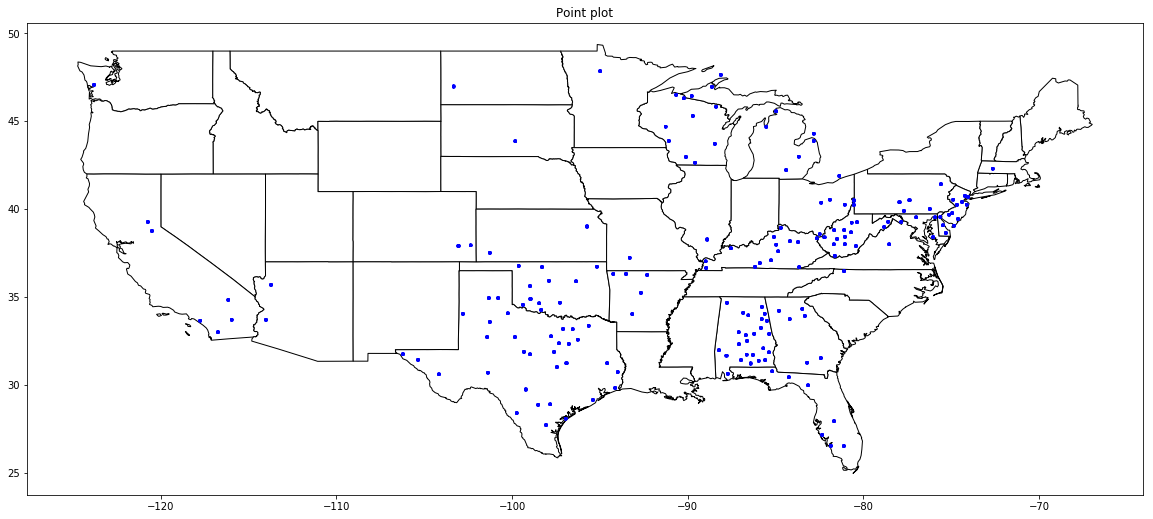

In [455]:
ax = us_map.plot(color='white', edgecolor='black', figsize=(20,20))

# We can now plot our GeoDataFrame.
data.plot(ax=ax, color='blue', markersize=1)

plt.title("Point plot")
plt.show()

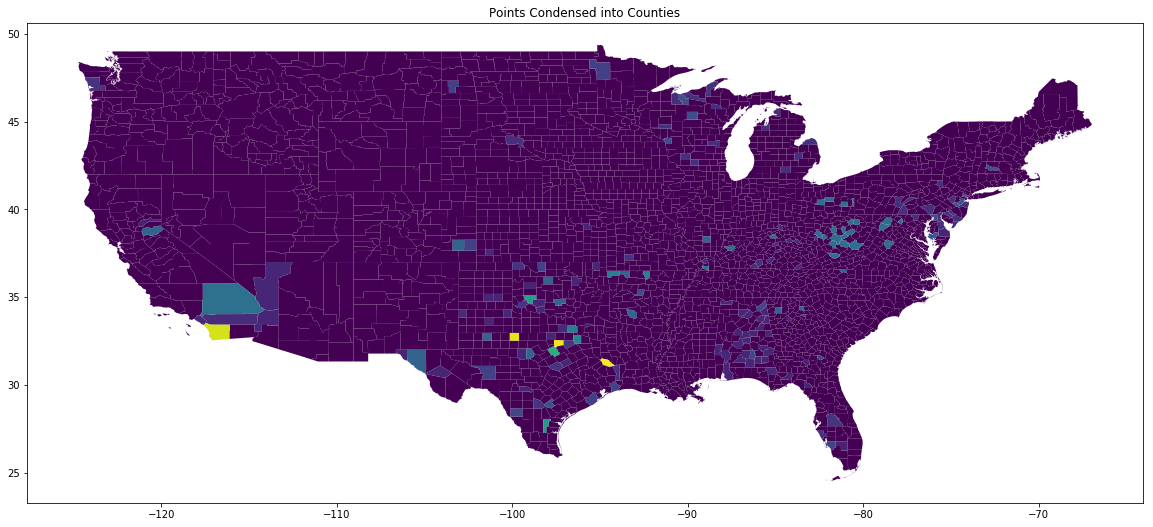

In [456]:
us_county_map = get_county_shapemap()

data.crs = us_county_map.crs
county_data = sjoin(data, us_county_map, how='left')
us_county_map.set_index("GEOID", inplace=True)
us_county_map['counts'] = county_data.groupby("GEOID")['x'].sum()
us_county_map.counts.fillna(0, inplace=True)

ax = us_county_map.plot(column="counts", figsize=(20,20))

# We can now plot our GeoDataFrame.
plt.title("Points Condensed into Counties")
plt.show()

In [100]:
def get_spatial_lag_quartiles(data, title="Spatial Lag Median Risk Quartiles", filename=None, color_map="GnBu"):
    us_county_map = get_county_shapemap()

    data.crs = us_county_map.crs
    county_data = sjoin(data, us_county_map, how='left')
    us_county_map.set_index("GEOID", inplace=True)
    us_county_map['counts'] = county_data.groupby("GEOID")['x'].sum()
    us_county_map.counts.fillna(0, inplace=True)

    # create a list of counties and all the counties that county borders from the geometry of the shape file
    # wq = pysal.weights.Queen.from_dataframe(us_county_map)
    wq = pysal.weights.DistanceBand.from_dataframe(us_county_map, threshold=2, binary=True)
    # weigh each county based on the total number of bordering counties
    wq.transform = 'r'

    # get the spatial lag for each county - based on all of the attrubute values we see in neighboring counties
    y = us_county_map['counts']
    ylag = pysal.weights.lag_spatial(wq,y)

    f, ax = plt.subplots(1, figsize=(20,20))
    us_county_map.assign(cl=ylag).plot(column='cl', categorical=True,
            k=5, cmap=color_map, linewidth=0.1, ax=ax,
            edgecolor='black')
    ax.set_axis_off()
    
    plt.title(title)
    if filename is not None:
        plt.savefig(filename)
    else:
        plt.show()
    
    

In [385]:
meta_type_colors = {
    'Wind':"BuGn",
    'Cold':"Blues",
    'Water':"PuBu",
    'Other':"Greens",
    'Heat':"YlOrRd"
}

In [ ]:
%%time
meta_type_colors = {
    'All':"Greys",
    'Wind':"BuGn",
    'Cold':"Blues",
    'Water':"PuBu",
    'Other':"Greens"
}
meta_type_colors = {
    'Heat':"YlOrRd"
}

for meta_type, color_map in meta_type_colors.items():
    date = datetime.strptime('01/01/18', '%m/%d/%y')
    while date.year<2019:
        if meta_type == "All":
            m = get_day_matrix(date, span=10)
        else:
            m = get_day_matrix(date, span=10, meta_type=meta_type)
        data = create_geopandas_from_matrix(m)
        if data is None:
            print("No data found for", date)
        else:
            get_spatial_lag_quartiles(
                data,
                title="Spatial Lag Median Risk Quartiles - {} - ({})".format(meta_type, str(date).split()[0]),
                filename="output/{0}_{1:02d}-{2:02d}.png".format(meta_type,date.month, date.day), 
                color_map=color_map)
        date = date + timedelta(days=7)

In [308]:
detail_data[detail_data.META_TYPE=="Heat"].head(5)

,FIPS,STATE,EVENT_TYPE,CZ_NAME,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,BEGIN_DATE,END_DATE,EVENT_CODE,META_TYPE,META_CODE
233094,01005,ALABAMA,Heat,LIMESTONE,31.870253,-85.405104,NaN,NaN,1996-02-27 23:00:00,1996-02-27 23:00:00,19,Heat,1
233191,54032,WEST VIRGINIA,Heat,TAYLOR,NaN,NaN,NaN,NaN,1996-02-27 12:00:00,1996-02-27 18:00:00,19,Heat,1
233215,54025,WEST VIRGINIA,Heat,LOGAN,37.924418,-80.450590,NaN,NaN,1996-02-27 12:00:00,1996-02-27 18:00:00,19,Heat,1
233245,54005,WEST VIRGINIA,Heat,WAYNE,38.022814,-81.713539,NaN,NaN,1996-02-27 12:00:00,1996-02-27 18:00:00,19,Heat,1
233246,54006,WEST VIRGINIA,Heat,CABELL,NaN,NaN,NaN,NaN,1996-02-27 12:00:00,1996-02-27 18:00:00,19,Heat,1


In [321]:
date = datetime.strptime('02/26/18', '%m/%d/%y')
m = get_day_matrix(date, span=10, meta_type="Heat")


In [322]:
m.nonzero()

(array([], dtype=int32), array([], dtype=int32))

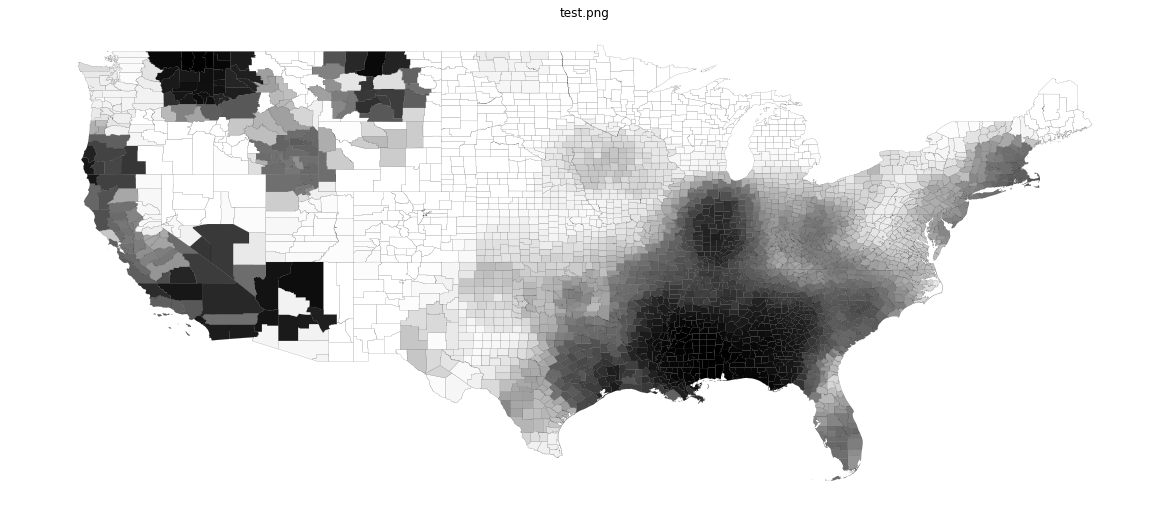

In [101]:
m.nonzero

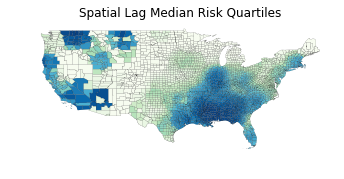

Wall time: 20.3 s


In [356]:
%%time
us_county_map = get_county_shapemap()

data.crs = us_county_map.crs
county_data = sjoin(data, us_county_map, how='left')
us_county_map.set_index("GEOID", inplace=True)
us_county_map['counts'] = county_data.groupby("GEOID")['x'].sum()
us_county_map.counts.fillna(0, inplace=True)

# create a list of counties and all the counties that county borders from the geometry of the shape file
# wq = pysal.weights.Queen.from_dataframe(us_county_map)
wq = pysal.weights.DistanceBand.from_dataframe(us_county_map, threshold=2, binary=True)
# weigh each county based on the total number of bordering counties
wq.transform = 'r'

# get the spatial lag for each county - based on all of the attrubute values we see in neighboring counties
y = us_county_map['counts']
ylag = pysal.weights.lag_spatial(wq,y)

f, ax = plt.subplots(1, figsize=(5.5, 2.5))
us_county_map.assign(cl=ylag).plot(column='cl', categorical=True,
        k=5, cmap='GnBu', linewidth=0.1, ax=ax,
        edgecolor='black')
ax.set_axis_off()
plt.title("Spatial Lag Median Risk Quartiles")
plt.show()

In [282]:
# https://en.wikipedia.org/wiki/Moran%27s_I
moran_i = esda.moran.Moran(y, wq)
print("Moran's I")
print("Observed: {:.4f} - Expected: {:.4f}".format(moran_i.I, moran_i.EI))
print("Z-value: {:.4f}".format(moran_i.z_norm))

Moran's I
Observed: 0.3793 - Expected: -0.0003
Z-value: 35.2880


In [281]:
geary_c = pysal.Geary(y, wq)
print("Geary's C")
print("Observed: {:.4f} - Expected: {:.4f}".format(geary_c.C, geary_c.EC))
print("Z-value: {:.4f}".format(geary_c.z_norm))

Geary's C
Observed: 0.6357 - Expected: 1.0000
Z-value: -32.1384


In [291]:
getisord_g = esda.getisord.G(y, wq)
print("Gettis Ord G")
print("Observed: {:.4f} - Expected: {:.4f}".format(getisord_g.G, getisord_g.EG))
print("Z-value: {:.4f}".format(getisord_g.z_norm))

Gettis Ord G
Observed: 0.0199 - Expected: 0.0019
Z-value: 40.9630


In [324]:
us_county_map.sort_values("counts", ascending=False).head(3)

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,NAME,LSAD,ALAND,AWATER,geometry,counts,cl
GEOID,,,,,,,,,,,
53043,53,043,01514052,0500000US53043,Lincoln,06,5984258952,75428245,"POLYGON ((-118.978798 47.36316, -118.9792 47.3...",81.015625,3 cold spot
12063,12,063,00295734,0500000US12063,Jackson,06,2378066857,94243008,"POLYGON ((-85.60006199999999 30.833783, -85.59...",76.808350,0 ns
28129,28,129,00695785,0500000US28129,Smith,06,1647926085,2599432,"POLYGON ((-89.73122499999999 32.164879, -89.73...",64.367188,1 hot spot


# Make Predictions

In [ ]:
us_county_map[us_county_map.NAME=="Sullivan"]

In [ ]:
def get_actual(lat, lon, month, search_range=.25):
    year = 2016
    start = "{:0d}-{:02d}-01".format(year, month)
    if month == 12:
        month = 1
        year += 1
    else:
        month+=1
    end = "{:0d}-{:02d}-01".format(year, month)
    threshold = 1/(search_range*search_range*100*100)/12
    event_count = len(detail_data[
        (detail_data.BEGIN_DATE>start) & 
        (detail_data.BEGIN_DATE<end) &
        (detail_data.BEGIN_LON > lon-search_range) &
        (detail_data.BEGIN_LON < lon+search_range) &
        (detail_data.BEGIN_LAT > lat-search_range) &
        (detail_data.BEGIN_LAT < lat+search_range)
    ])
    seen_per = event_count/(search_range*search_range*3*100*100)
    
    return seen_per>threshold, seen_per/threshold, seen_per


In [ ]:
def search(lat,long,month,search_range=25):
    col_center = lat_to_index(lat)
    row_center = lon_to_index(long)

    event_count = 0
    total_count = 0
    y = {}
    for year in range(1996,2015):
        m = mats[str(year)]["{:02d}".format(month)]
        y[year] = 0

        for col in range(col_center-search_range, col_center+search_range+1):
            for row in range(row_center-search_range, row_center+search_range+1):
                if row >= 0 and row <= 5782 and col >= 0 and col <= 2459:
                    total_count += 1
                    val = m[row,col]
                    if val > 0:
                        event_count += val
                        y[year] += val
                    
    count = 0
    for e in y.values():
        if e > 30:
            count += 1
    prob = min(count/len(d)*4,.99)
    
    return prob > 0.6, prob

In [ ]:
lat,long,month = 42.16,-83.44,7
print("Ann Arbor", search(lat,long,month), get_actual(lat,long,month))

In [ ]:
d = {1996: 0, 1997: 0, 1998: 0, 1999: 0, 2000: 0, 2001: 0, 2002: 0, 2003: 0, 2004: 0, 2005: 0, 2006: 0, 2007: 219, 2008: 49, 2009: 0, 2010: 285, 2011: 756, 2012: 253, 2013: 139, 2014: 131}

In [ ]:
count = 0
for e in d.values():
    if e > 30:
        count += 1
count/len(d)

In [ ]:
import random
correct = 0
total = 0
pos = 0
for random_sample_row in detail_data[(detail_data.BEGIN_DATE>'2015-01-01') & (detail_data.BEGIN_DATE<'2016-01-01')].dropna().sample(5).iterrows():
    random_sample_row = random_sample_row[1]
    lat,lon = random_sample_row.BEGIN_LAT, random_sample_row.BEGIN_LON
    event_type = random_sample_row.EVENT_TYPE
    month = random.randint(1,12)
    
    prediction = search(lat,lon,month)
    actual = get_actual(lat,lon,month)
    
#     print("({}/{}-{}) {} - Prediction: {}, Actual: {}".format(lat,lon,month,event_type,prediction,actual))
    
    total += 1
    if prediction[0] == actual[0]:
        correct += 1
    if prediction[0]:
        pos += 1

print("total: {:2f}".format(correct/total*100))
print("positives:",pos)

In [ ]:
%%time
import random
correct = 0
total = 0
results = {"pos":0,"neg":0,"false_pos":0,"false_neg":0}
over_99 = {"pos":0,"neg":0}
for random_sample_row in detail_data[(detail_data.BEGIN_DATE>'2015-01-01') & (detail_data.BEGIN_DATE<'2016-01-01')].dropna().sample(5).iterrows():
    random_sample_row = random_sample_row[1]
    lat,lon = random_sample_row.BEGIN_LAT, random_sample_row.BEGIN_LON
    month = random.randint(1,12)
    
    prediction = search(lat,lon,month)
    actual = get_actual(lat,lon,month)
    
    print("({}/{}-{}) Prediction: {}, Actual: {}".format(lat,lon,month,prediction,actual))
    
    total += 1
    if prediction[0] == actual[0]:
        correct += 1
    
    if prediction[0] == True and actual[0] == True:
        results["pos"] += 1
    elif prediction[0] == False and actual[0] == False:
        results["neg"] += 1
    elif prediction[0] == True and actual[0] == False:
        results["false_pos"] += 1
    elif prediction[0] == False and actual[0] == True:
        results["false_neg"] += 1
        
    if prediction[1] == 0.99:
        if actual[0] == True:
            over_99['pos'] += 1
        else:
            over_99['neg'] += 1
        

print("total: {:2f}".format(correct/total*100))
print(results)
print(over_99)

In [ ]:
(122+244)/500
67/500

In [ ]:
lat,long,month = 40.71,-74.00,1
print("Chicago", search(lat,long,month), get_actual(lat,long,month))

lat,long,month = 42.21,71.03,3
print("Boston", search(lat,long,month), get_actual(lat,long,month))

lat,long,month = 42.16,-83.44,7
print("Ann Arbor", search(lat,long,month), get_actual(lat,long,month))


lat,long,month = 29.99,-91.07,2
print("Assumption, LA", search(lat,long,month), get_actual(lat,long,month))

lat,long,month = 34.73,-96.15,5
print("Caddo, OK", search(lat,long,month), get_actual(lat,long,month))

lat,long,month = 29.86,-95.39,5
print("Harris, TX", search(lat,long,month), get_actual(lat,long,month))


lat,long,month = 34.05,-118.25,6
print("Los Angeles", search(lat,long,month), get_actual(lat,long,month))

lat,long,month = 32.42, -117.09,7
print("San Diego", search(lat,long,month), get_actual(lat,long,month))

lat,long,month = 34.16, -118.44,11
print("Simi Valley", search(lat,long,month), get_actual(lat,long,month))

lat,long,month = 38.5, -104.494,7
print("Colorado Springs", search(lat,long,month), get_actual(lat,long,month))

In [ ]:
for month in range(1,13):
    lat,long = 34.05,-118.25
    print("Los Angeles", search(lat,long,month), get_actual(lat,long,month))